<a href="https://colab.research.google.com/github/ArivCR7/Generic-Neural-Net/blob/master/NeuralNetTemplate_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import imageio
import time
from IPython.display import HTML
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_moons, make_blobs, make_circles

In [0]:
data, label = make_moons(n_samples=1000, noise=0.2, random_state=0)
print(data.shape, label.shape)

(1000, 2) (1000,)


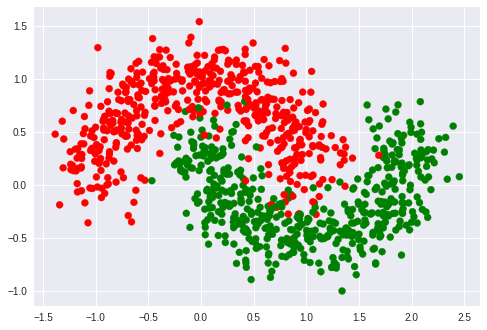

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])
plt.scatter(data[:,0], data[:,1], c=label, cmap=my_cmap)
plt.show()

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(data, label, stratify=label, random_state=0)
print(X_train.shape, Y_train.shape)

(750, 2) (750,)


In [0]:
Y_train_reshaped = Y_train.reshape(-1,1)

# Neural Network Class

In [0]:
class NeuralNet:
  def __init__(self, nx, ny, hidden_sizes, algo='GD'):
    self.nx = nx
    self.ny = ny
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    self.algo = algo
    if(self.ny>2):
      self.type="multiclass"
    else:
      self.type="binary"
    
    self.params={}
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(self.nh+1):
      self.params['W'+str(i+1)] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.params['B'+str(i+1)] = np.zeros((1,self.sizes[i+1]))
      self.update_params['v_w'+str(i+1)] = 0
      self.update_params['v_b'+str(i+1)] = 0
      self.update_params['m_w'+str(i+1)] = 0
      self.update_params['m_b'+str(i+1)] = 0
      self.prev_update_params['v_w'+str(i+1)] = 0
      self.prev_update_params['v_b'+str(i+1)] = 0
       
  def sigmoid(self, X):
    return(1.0/(1.0 + np.exp(-X)))
  
  def grad_sigmoid(self, X):
    return (X * (1-X))
  
  def softmax(self, X):
    exps = np.exp(X)
    return(exps/np.sum(exps, axis=1).reshape(-1,1))
    
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    if(self.type=='muliclass'):
      return(np.array(Y_pred).squeeze())
    else:
      return(np.array(Y_pred))
 
  def forward_pass(self, X, params=None):
    self.A = {}
    self.H = {}
    self.H[0] = X
    if(params is None):
      params = self.params
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], params['W'+str(i+1)])
      self.H[i+1] = self.sigmoid(self.A[i+1])
    #compute last layer separately
    L = self.nh+1
    self.A[L] = np.matmul(self.H[self.nh], self.params['W'+str(L)])
    if(self.type=='multiclass'):
      self.H[L] = self.softmax(self.A[L])
    else:
      self.H[L] = self.sigmoid(self.A[L])
    return(self.H[L])
  
  def grad(self, X, Y, params=None):
    if(params is None):
      params = self.params
    self.forward_pass(X, params)
    L = self.nh+1
    self.gradients['dA'+str(L)] = self.H[L] - Y
    for i in range(L,0,-1):
      self.gradients['dW'+str(i)] = np.matmul(self.H[i-1].T, self.gradients['dA'+str(i)])
      self.gradients['dB'+str(i)] = np.sum(self.gradients['dA'+str(i)], axis=0)
      self.gradients['dH'+str(i-1)] = np.matmul(self.gradients['dA'+str(i)], params['W'+str(i)].T)
      self.gradients['dA'+str(i-1)] = np.multiply(self.gradients['dH'+str(i-1)], self.grad_sigmoid(self.H[i-1]))
  
  def fit(self, X, Y, epochs=100, eta=0.1, mini_batch_size=100, gamma=0.8, epsilon=1e-8, beta=0.9, beta1=0.9, beta2=0.9, display_loss=True):
    
    if(display_loss):
      loss = {}
    
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):    
      m = X.shape[0]
      if(self.algo=='GD'):
        self.grad(X, Y)
        for i in range(self.nh+1):
          self.params['W'+str(i+1)] -= eta * self.gradients['dW'+str(i+1)]/m
          self.params['B'+str(i+1)] -= eta * self.gradients['dB'+str(i+1)]/m
      
      elif(self.algo=='minibatchgd'):
        for k in range(0, m, mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(self.nh+1):
            self.params['W'+str(i+1)] -= eta * self.gradients['dW'+str(i+1)]/mini_batch_size
            self.params['B'+str(i+1)] -= eta * self.gradients['dB'+str(i+1)]/mini_batch_size        
      
      elif(self.algo=='Momentum'):
        self.grad(X, Y)
        for i in range(self.nh+1):
          self.update_params['v_w'+str(i+1)] = gamma * self.update_params['v_w'+str(i+1)] + eta * self.gradients['dW'+str(i+1)]/m
          self.update_params['v_b'+str(i+1)] = gamma * self.update_params['v_b'+str(i+1)] + eta * self.gradients['dB'+str(i+1)]/m
          self.params['W'+str(i+1)] -= self.update_params['v_w'+str(i+1)]
          self.params['B'+str(i+1)] -= self.update_params['v_b'+str(i+1)]
      
      elif(self.algo=='NAG'):
        temp_params = {}
        for i in range(self.nh+1):
          self.update_params["v_w"+str(i+1)]=gamma*self.prev_update_params["v_w"+str(i+1)]
          self.update_params["v_b"+str(i+1)]=gamma*self.prev_update_params["v_b"+str(i+1)]
          temp_params["W"+str(i+1)]=self.params["W"+str(i+1)]-self.update_params["v_w"+str(i+1)]
          temp_params["B"+str(i+1)]=self.params["B"+str(i+1)]-self.update_params["v_b"+str(i+1)]
        self.grad(X,Y,temp_params)
        for i in range(self.nh+1):
          self.update_params["v_w"+str(i+1)] = gamma *self.update_params["v_w"+str(i+1)] + eta * (self.gradients["dW"+str(i+1)]/m)
          self.update_params["v_b"+str(i+1)] = gamma *self.update_params["v_b"+str(i+1)] + eta * (self.gradients["dB"+str(i+1)]/m)
          self.params["W"+str(i+1)] -= eta * (self.update_params["v_w"+str(i+1)])
          self.params["B"+str(i+1)] -= eta * (self.update_params["v_b"+str(i+1)]) 
        self.prev_update_params=self.update_params
        
      elif(self.algo=='AdaGrad'):
        self.grad(X, Y)
        for i in range(self.nh+1):
          self.update_params['v_w'+str(i+1)] += self.gradients['dW'+str(i+1)]**2
          self.update_params['v_b'+str(i+1)] += self.gradients['dB'+str(i+1)]**2
          self.params['W'+str(i+1)] -= eta/(np.sqrt(self.update_params['v_w'+str(i+1)])+epsilon)*self.gradients['dW'+str(i+1)]
          self.params['B'+str(i+1)] -= eta/(np.sqrt(self.update_params['v_b'+str(i+1)])+epsilon)*self.gradients['dB'+str(i+1)]
      
      elif(self.algo=='RMSProp'):
        self.grad(X, Y)
        for i in range(self.nh+1):
          self.update_params['v_w'+str(i+1)] = beta*self.update_params['v_w'+str(i+1)] + (1-beta)*self.gradients['dW'+str(i+1)]**2
          self.update_params['v_b'+str(i+1)] = beta*self.update_params['v_b'+str(i+1)] + (1-beta)*self.gradients['dB'+str(i+1)]**2
          self.params['W'+str(i+1)] -= eta/(np.sqrt(self.update_params['v_w'+str(i+1)])+epsilon)*self.gradients['dW'+str(i+1)]
          self.params['B'+str(i+1)] -= eta/(np.sqrt(self.update_params['v_b'+str(i+1)])+epsilon)*self.gradients['dB'+str(i+1)]
      
      elif(self.algo=='Adam'):
        self.grad(X,Y)
        num_updates=0
        for i in range(self.nh+1):
          num_updates+=1
          self.update_params['m_w'+str(i+1)] = beta1*self.update_params['m_w'+str(i+1)] + (1-beta1)*self.gradients['dW'+str(i+1)]
          self.update_params['m_b'+str(i+1)] = beta1*self.update_params['m_b'+str(i+1)] + (1-beta1)*self.gradients['dB'+str(i+1)]
          self.update_params['v_w'+str(i+1)] = beta2*self.update_params['v_w'+str(i+1)] + (1-beta2)*self.gradients['dW'+str(i+1)]**2
          self.update_params['v_b'+str(i+1)] = beta2*self.update_params['v_b'+str(i+1)] + (1-beta2)*self.gradients['dB'+str(i+1)]**2
          m_w_c = self.update_params['m_w'+str(i+1)] / (1 - np.power(beta1, num_updates))
          m_b_c = self.update_params['m_b'+str(i+1)] / (1 - np.power(beta1, num_updates))
          v_w_c = self.update_params['v_w'+str(i+1)] / (1 - np.power(beta1, num_updates))
          v_b_c = self.update_params['v_b'+str(i+1)] / (1 - np.power(beta1, num_updates))
          self.params['W'+str(i+1)] -= eta/(np.sqrt(v_w_c)+epsilon)*m_w_c
          self.params['B'+str(i+1)] -= eta/(np.sqrt(v_b_c)+epsilon)*m_b_c
          
      if(display_loss):
        Y_pred = self.predict(X)
        if(self.type=='multiclass'):
          loss[epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
        else:
          loss[epoch] = log_loss(Y, Y_pred)
        #print(loss[epoch])
      
    
    if(display_loss):
      plt.plot(loss.values(), '-o', markersize=5)
      plt.xlabel('Epochs')
      plt.ylabel('Log loss')
      plt.show()
      
      
      

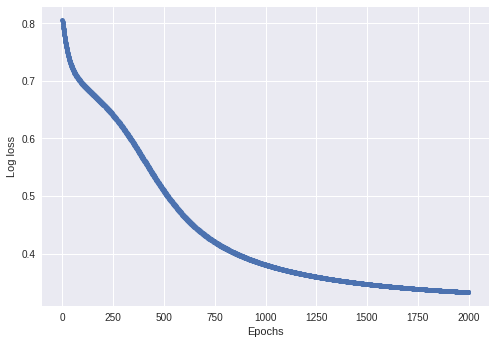

In [0]:
nnet_gd = NeuralNet(X_train.shape[1], Y_train_reshaped.shape[1], [3, 4], algo='GD')
nnet_gd.fit(X_train, Y_train_reshaped, epochs=2000)

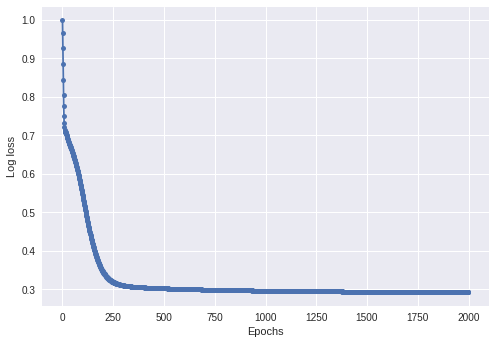

In [0]:
nnet_m = NeuralNet(X_train.shape[1], Y_train_reshaped.shape[1], [3, 4], algo='Momentum')
nnet_m.fit(X_train, Y_train_reshaped, epochs=2000)

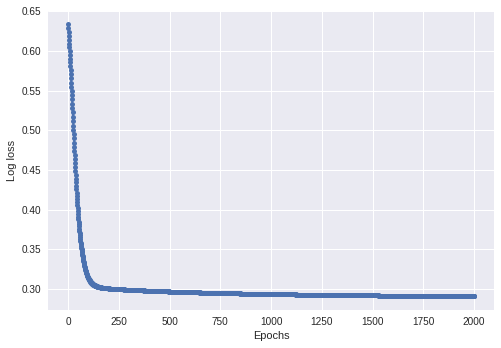

In [0]:
nnet_mini = NeuralNet(X_train.shape[1], Y_train_reshaped.shape[1], [3, 4], algo='minibatchgd')
nnet_mini.fit(X_train, Y_train_reshaped, epochs=2000)

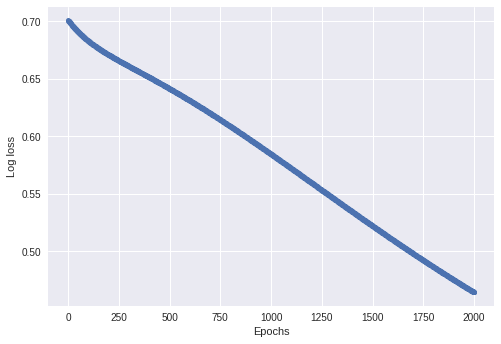

In [0]:
nnet_nag = NeuralNet(X_train.shape[1], Y_train_reshaped.shape[1], [3, 4], algo='NAG')
nnet_nag.fit(X_train, Y_train_reshaped, epochs=2000)

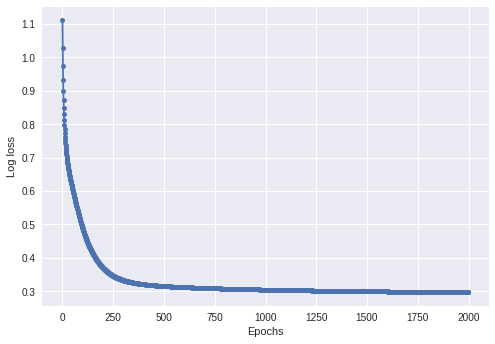

In [0]:
nnet_adag = NeuralNet(X_train.shape[1], Y_train_reshaped.shape[1], [3, 4], algo='AdaGrad')
nnet_adag.fit(X_train, Y_train_reshaped, epochs=2000)

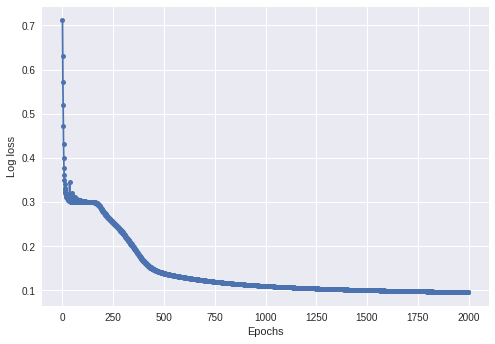

In [0]:
nnet_rms = NeuralNet(X_train.shape[1], Y_train_reshaped.shape[1], [3, 4], algo='RMSProp')
nnet_rms.fit(X_train, Y_train_reshaped, epochs=2000)

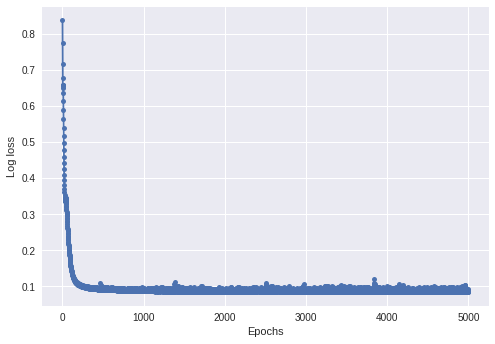

In [0]:
nnet_adam = NeuralNet(X_train.shape[1], Y_train_reshaped.shape[1], [3, 4], algo='Adam')
nnet_adam.fit(X_train, Y_train_reshaped, epochs=5000)

RMSProp Optimizer seems to be the best one in this case!!!

In [0]:
def print_plot_acc(X_train, Y_train, X_test, Y_test, nnet):
  Y_train_pred = nnet.predict(X_train)
  Y_train_pred = (Y_train_pred>0.5).astype('int').ravel()
  train_acc = accuracy_score(Y_train, Y_train_pred)
  Y_test_pred = nnet.predict(X_test)
  Y_test_pred = (Y_test_pred>0.5).astype('int').ravel()
  test_acc  = accuracy_score(Y_test, Y_test_pred)
  print('train accuracy: {}, test_accuracy: {}'.format(train_acc,test_acc))
  fig, ax1 = plt.subplots()
  ax1.scatter(X_train[:,0],X_train[:,1], c=Y_train_pred, cmap=my_cmap, s=(10*np.abs(Y_train_pred - Y_train)+1))
  ax1.set_title('Train data plot')
  fig, ax2 = plt.subplots()
  ax2.scatter(X_test[:,0],X_test[:,1], c=Y_test_pred, cmap=my_cmap, s=(10*np.abs(Y_test_pred - Y_test)+1))
  ax2.set_title('Test data plot')
  

train accuracy: 0.9626666666666667, test_accuracy: 0.976


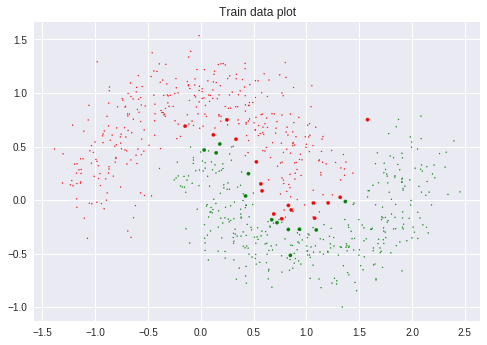

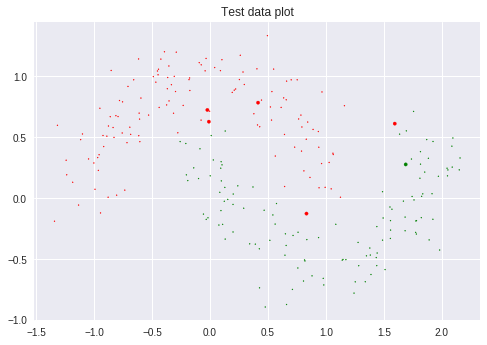

In [0]:
print_plot_acc(X_train, Y_train, X_test, Y_test, nnet_adam)

# Multi class classification with different config

In [3]:
data, label = make_blobs(n_samples=1000, n_features=2, centers=4, random_state=0)
print(data.shape, label.shape)

(1000, 2) (1000,)


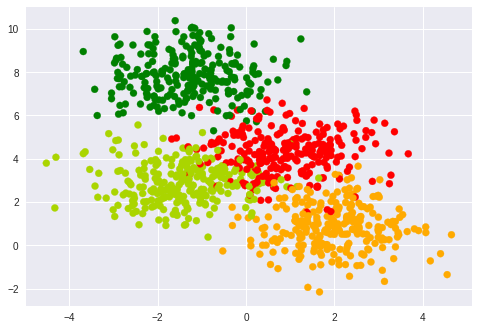

In [5]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])
plt.scatter(data[:,0], data[:,1], c=label, cmap=my_cmap)
plt.show()

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(data, label, stratify = label, random_state=0)
print(X_train.shape, Y_train.shape)

(750, 2) (750,)


In [7]:
enc = OneHotEncoder()
Y_train_OH = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
Y_test_OH  = enc.fit_transform(np.expand_dims(Y_test,1)).toarray()
print(Y_train_OH.shape, Y_test_OH.shape)

(750, 4) (250, 4)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

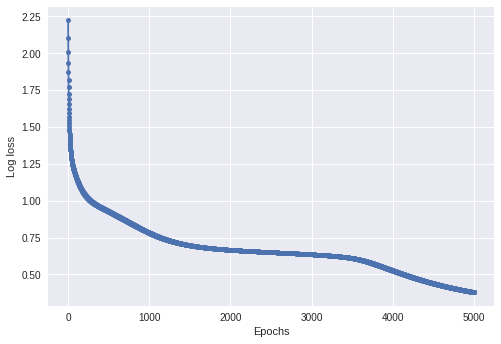

In [8]:
nnet_multi_gd = NeuralNet(2, 4, [3, 4], algo='GD')
nnet_multi_gd.fit(X_train, Y_train_OH, epochs=5000)

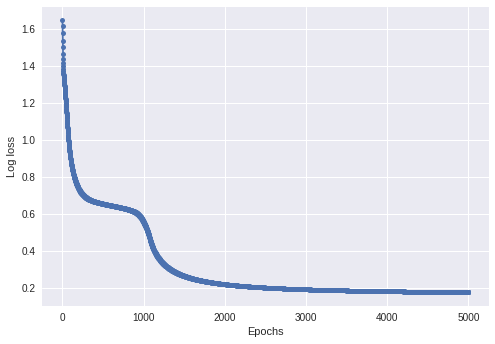

In [9]:
nnet_multi_gd = NeuralNet(2, 4, [3, 4], algo='Momentum')
nnet_multi_gd.fit(X_train, Y_train_OH, epochs=5000)

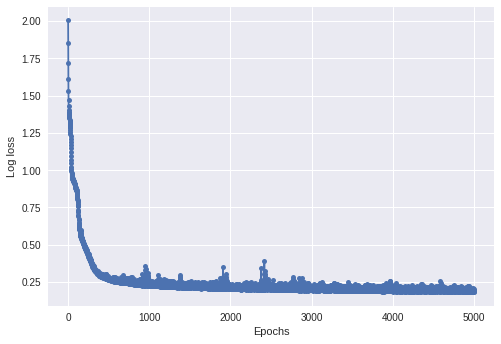

In [18]:
nnet_multi_adam = NeuralNet(2, 4, [2, 3], algo='Adam')
nnet_multi_adam.fit(X_train, Y_train_OH, epochs=5000)

In [0]:
def print_plot_acc_multi(X_train, Y_train, X_test, Y_test, nnet):
  Y_train_pred = nnet.predict(X_train)
  Y_train_pred = np.argmax(Y_train_pred, axis=1)
  train_acc = accuracy_score(Y_train, Y_train_pred)
  Y_test_pred = nnet.predict(X_test)
  Y_test_pred = np.argmax(Y_test_pred, axis=1)
  test_acc  = accuracy_score(Y_test, Y_test_pred)
  print('train accuracy: {}, test_accuracy: {}'.format(train_acc,test_acc))
  fig, ax1 = plt.subplots()
  ax1.scatter(X_train[:,0],X_train[:,1], c=Y_train_pred, cmap=my_cmap, s=(10*np.abs(Y_train_pred - Y_train)+1))
  ax1.set_title('Train data plot')
  fig, ax2 = plt.subplots()
  ax2.scatter(X_test[:,0],X_test[:,1], c=Y_test_pred, cmap=my_cmap, s=(10*np.abs(Y_test_pred - Y_test)+1))
  ax2.set_title('Test data plot')

train accuracy: 0.9186666666666666, test_accuracy: 0.94


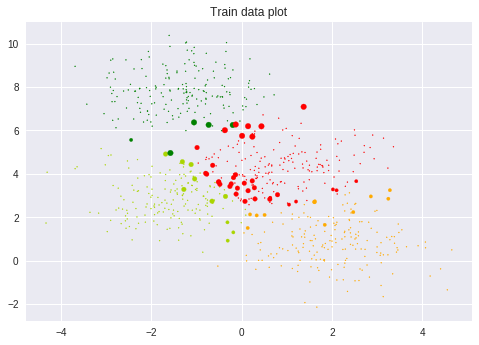

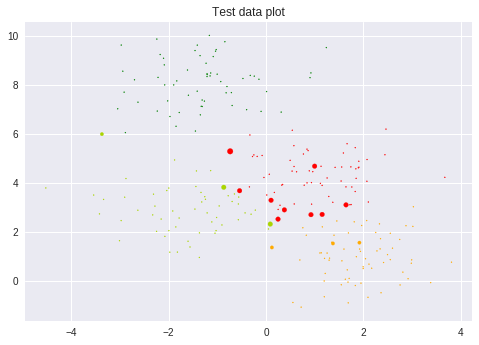

In [23]:
print_plot_acc_multi(X_train, Y_train, X_test, Y_test, nnet_multi_adam)